In [205]:
import sys
sys.path.append('../../')

from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils,
    constants,
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.graphics.gofplots import qqplot
from scipy import ndimage as ndi
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)
reload(constants)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [472]:
meta_dir = Path("/Users/sean/code/pharynx_redox/data/paired_ratio/")

prof_raw = da.load_all_cached_profile_data(meta_dir, '**/*new_idx_regionwise/*untrimmed_profile_data.nc')
prof_reg = da.load_all_cached_profile_data(meta_dir, '**/*matlab_reg/*untrimmed_profile_data-reindexed.nc')
# prof_raw.sel(experiment=np.unique(prof_raw.experiment.values)[1], pair=0)
# prof_raw.spec.values

In [320]:
m_0_0, m_0_1, m_1_0, m_1_1 = da.split_by_movement_types(da.mvmt_long_to_wide(da.load_all_movement(meta_dir)), 'posterior')

In [342]:
regions = utils.scale_region_boundaries(constants.untrimmed_regions, 200)

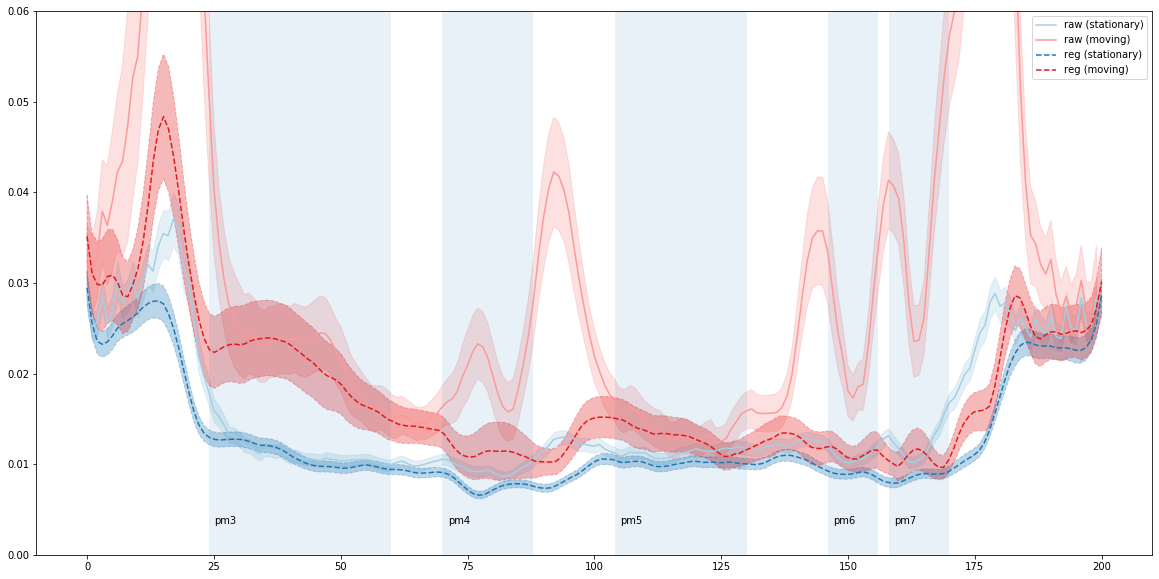

In [479]:
fig, ax = plt.subplots(figsize=(20,10))

cmap = plt.get_cmap('Paired').colors

# ax2 = plt.twinx();
# plots.plot_profile_avg_with_bounds(prof_raw.sel(wavelength='410', pair=0), ax=ax2, color='gray', alpha=.1);

prof_raw_stationary = prof_raw.sel(spec=m_0_0.index)
prof_raw_moving = xr.concat([prof_raw.sel(spec=m_0_1.index), prof_raw.sel(spec=m_1_0.index)], dim='spec')

prof_reg_stationary = prof_reg.sel(spec=m_0_0.index)
prof_reg_moving = xr.concat([prof_reg.sel(spec=m_0_1.index), prof_reg.sel(spec=m_1_0.index)], dim='spec')


plots.plot_profile_avg_with_bounds(da.fold_error(prof_raw_stationary), ax=ax, label='raw (stationary)', color=cmap[0])
plots.plot_profile_avg_with_bounds(da.fold_error(prof_raw_moving), ax=ax, label='raw (moving)', color=cmap[4])

plots.plot_profile_avg_with_bounds(da.fold_error(prof_reg_stationary), ax=ax, label='reg (stationary)', xs=np.linspace(0,200,prof_reg_stationary.shape[-1]), color=cmap[1], linestyle='--')
plots.plot_profile_avg_with_bounds(da.fold_error(prof_reg_moving), ax=ax, label='reg (moving)', xs=np.linspace(0,200,prof_reg_moving.shape[-1]), color=cmap[5], linestyle='--')


plots.add_regions_to_axis(ax, regions)
ax.legend()
ax.set_ylim(0,0.06);

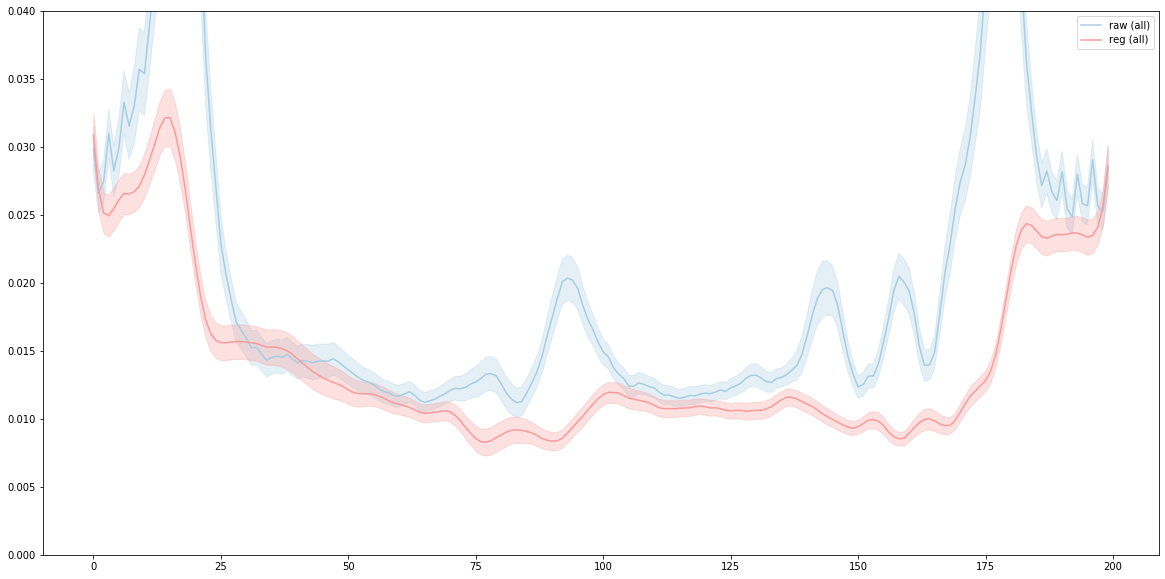

In [485]:
fig, ax = plt.subplots(figsize=(20,10))

plots.plot_profile_avg_with_bounds(da.fold_error(prof_raw), ax=ax, label='raw (all)', color=cmap[0])
plots.plot_profile_avg_with_bounds(da.fold_error(prof_reg), ax=ax, label='reg (all)', color=cmap[4])
ax.legend();
ax.set_ylim(0,0.04);

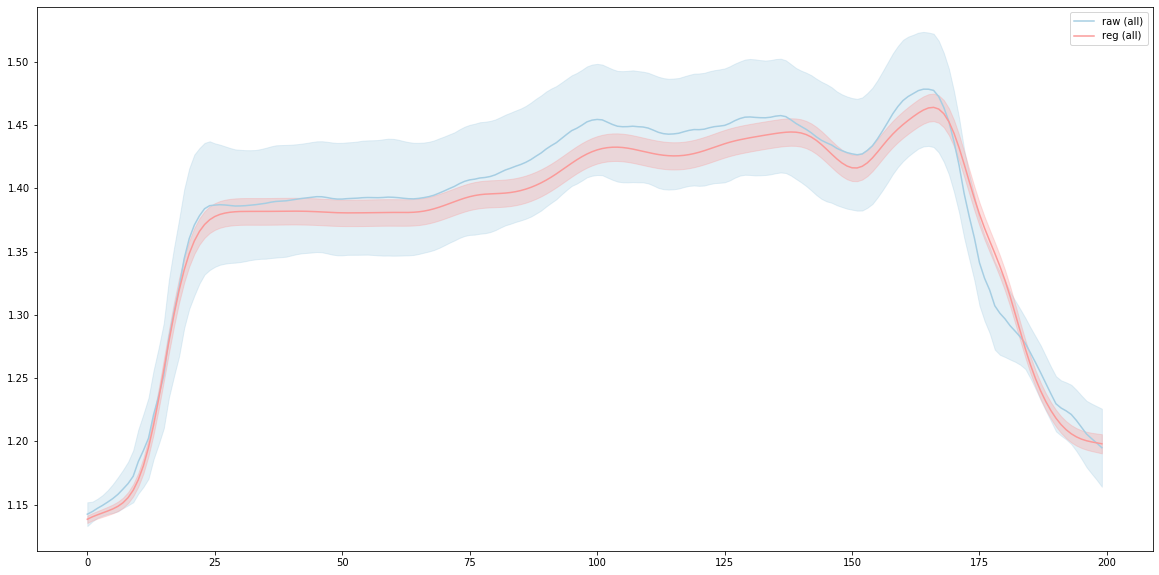

In [490]:
fig, ax = plt.subplots(figsize=(20,10))

plots.plot_profile_avg_with_bounds(raw.sel(wavelength='r').mean(dim='pair'), ax=ax, label='raw (all)', color=cmap[0])
reg_r = prof_reg.sel(wavelength='410') / prof_reg.sel(wavelength='470')
plots.plot_profile_avg_with_bounds(reg_r.mean(dim='pair'), ax=ax, label='reg (all)', color=cmap[4])
ax.legend();
# ax.set_ylim(0,0.04);

In [471]:
meta_dir = Path('/Users/sean/code/pharynx_redox/data/paired_ratio/')
for exp_dir in filter(lambda x: x.is_dir(), meta_dir.glob('*')):
    for trim_status in ['trimmed', 'untrimmed']:
        reg_old_path = list(exp_dir.glob(f'analyses/*matlab_reg/*-{trim_status}_profile_data.nc'))[0]
        raw_path =     list(exp_dir.glob(f'analyses/*new_idx_regionwise/*-{trim_status}_profile_data.nc'))[0]
        
        reg_old = xr.load_dataarray(reg_old_path)
        raw = xr.load_dataarray(raw_path)

        
        try:
            reg_new = raw.copy().sel(wavelength=['470', '410'])
            reg_new.values = reg_old.values
        except ValueError:
            reg_new = raw.copy()
            reg_new.values = reg_old.values
#             print(f'reg_old Shape: {reg_old.shape}')
#             print(f'reg_new Shape: {reg_new.shape}')
#             break
        newpath = reg_old_path.parent.joinpath(reg_old_path.stem + '-reindexed.nc')
        print(f'saving to {newpath}')
        reg_new.to_netcdf(newpath)

saving to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-09-23_matlab_reg/2017_08_23-HD233_4mm_lev-trimmed_profile_data-reindexed.nc
saving to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-09-23_matlab_reg/2017_08_23-HD233_4mm_lev-untrimmed_profile_data-reindexed.nc
saving to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-23_matlab_reg/2017_02_22-HD233_SAY47-trimmed_profile_data-reindexed.nc
saving to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-23_matlab_reg/2017_02_22-HD233_SAY47-untrimmed_profile_data-reindexed.nc
saving to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93/analyses/2019-09-23_matlab_reg/2017_08_25-HD233_SAY93-trimmed_profile_data-reindexed.nc
saving to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93/analyses/2019-09-23_matlab_reg/2017_08_25-HD233_SAY93-un